# Use pretrained VGG16 network

In [1]:
from tensorflow import keras 
from keras.applications.vgg16 import VGG16
vggmodel = VGG16(weights='imagenet', include_top=True)

In [2]:
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Read image

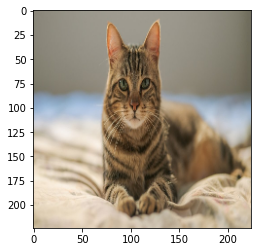

In [3]:
import matplotlib.pyplot as plt

import cv2
img = cv2.imread('/content/cat.jpeg')
img = cv2.resize(img,(224,224))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()


In [4]:
img = img.reshape((1,*img.shape))

In [5]:
print(img.shape)

(1, 224, 224, 3)


# predict the probability across all output classes

In [6]:
pred = vggmodel.predict(img)

In [7]:
from keras.applications.vgg16 import decode_predictions
decode_predictions(pred,top=3)[0]

[('n02124075', 'Egyptian_cat', 0.8865885),
 ('n02123159', 'tiger_cat', 0.049647406),
 ('n02123045', 'tabby', 0.045793813)]

In [8]:
model = VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')

In [9]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
layers = ['block1_conv1','block3_conv2'] #64,512

outputs = []
for l in model.layers:
    if l.name in layers:
        outputs.append(l.output)

In [11]:
outputs

[<KerasTensor: shape=(None, 224, 224, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv2')>]

In [12]:
# Functional API
from keras.models import Model
activation_model  = Model(inputs=model.input,outputs=outputs) # Creates a model that will return these outputs, given the model input

# Running the model in predict mode

In [13]:
l1,l2 = activation_model.predict(img)

In [14]:
img_l1 = l1[0]
print(img_l1.shape)

(224, 224, 64)


In [23]:
activations = activation_model.predict(img)

In [24]:
first_layer_activation = activations[0] #this is the activation of the first convolution layer for the image input:
print(first_layer_activation.shape)

(1, 224, 224, 64)


## It’s a 224 × 224 feature map with 64 channels. Let’s try plotting the fourth channel of the activation of the first layer of the original model

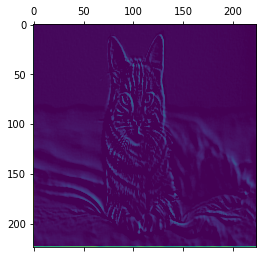

In [25]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

# Second activation layer

In [26]:
second_layer_activation = activations[1]
print(second_layer_activation.shape)

(1, 56, 56, 256)


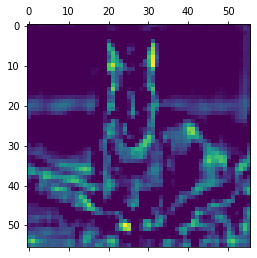

In [27]:
plt.matshow(second_layer_activation[0, :, :, 4], cmap='viridis')

# Visualizing every channel in every intermediate activation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


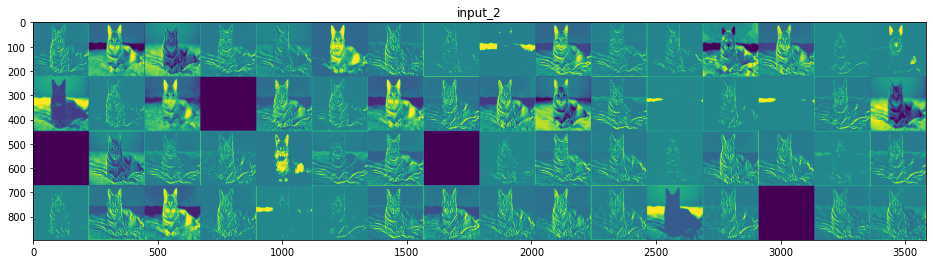

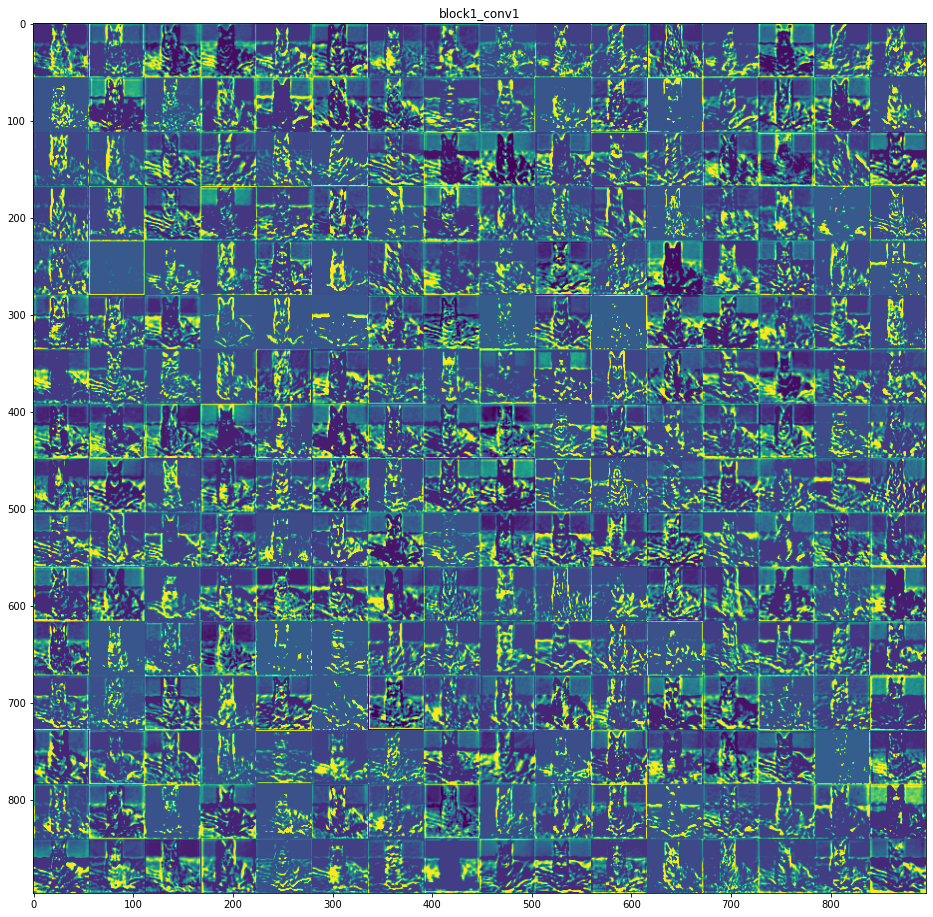

In [29]:
layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')


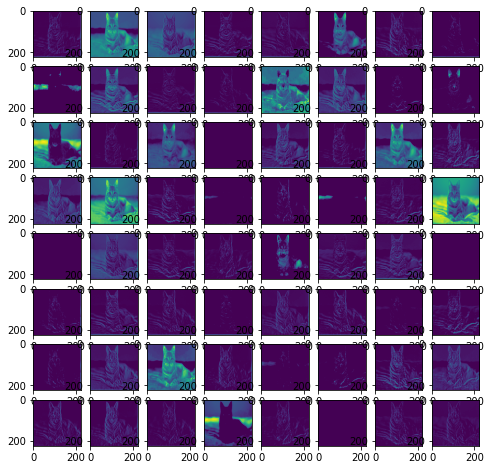

In [30]:
plt.figure(figsize=(8,8))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(img_l1[...,i],aspect='auto',cmap='viridis')
    
plt.show()

In [16]:
img_l2 = l2[0]
print(img_l2.shape)

(56, 56, 256)


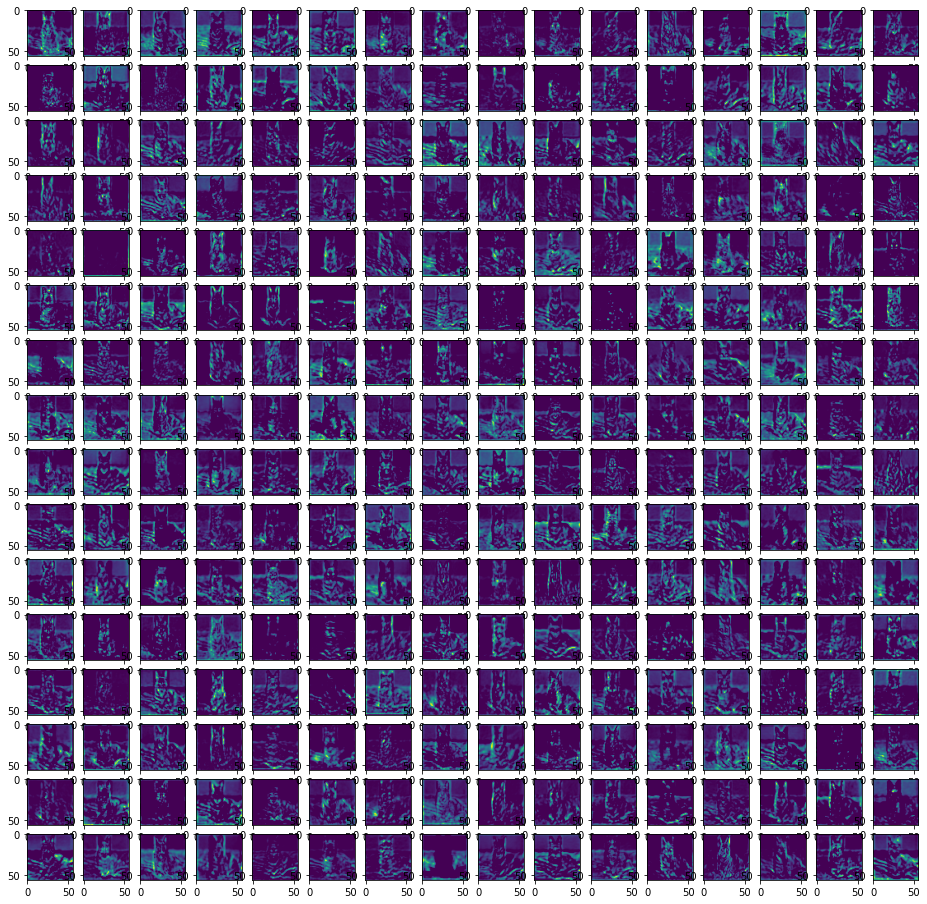

In [17]:
plt.figure(figsize=(16,16))
for i in range(256):
    plt.subplot(16,16,i+1)
    plt.imshow(img_l2[...,i],cmap='viridis')
    
plt.show()
